## Imports

In [1]:
import pandas as pd
import numpy as np
import re
import io
import matplotlib.pyplot as plt
import datetime
import nltk
import seaborn as sns
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalAveragePooling1D, LSTM, Dense, Dropout, BatchNormalization, Input
from gensim.models import Word2Vec
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

2024-08-26 01:53:13.881125: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-26 01:53:13.884497: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-26 01:53:13.894878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-26 01:53:13.911526: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-26 01:53:13.916462: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-26 01:53:13.927888: I tensorflow/core/platform/cpu_feature_gu

## Setup

PS: É necessário ter a base de dados em seu computador local e inserir o caminho para ela na constante ``DATA_PATH`` 

In [11]:
DATA_PATH = './data/data.csv'

nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

df = pd.read_csv(DATA_PATH, sep=';')

[nltk_data] Downloading package stopwords to /home/caze/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/caze/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Limpando a base

In [3]:
df.dropna(axis=1, how="all", inplace=True)
df.dropna(axis=0, how="all", inplace=True)

df.rename(columns={"Resposta\n": "Resposta"}, inplace=True)

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'[^\w\s]', ' ', text) 
    text = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return " ".join(text)

df['Pergunta'] = df['Pergunta'].apply(clean_text)
df['Intencao'] = df['Pergunta'].apply(clean_text)

df.head()

,No,Intencao,Pergunta,Resposta
0,1.0,boa dia tudo bem eu gostaria de saber sobre aq...,boa dia tudo bem eu gostaria de saber sobre aq...,"Bom dia! Sim, o sr pode utilizar o cartão de d..."
1,2.0,como enviar dinheiro japão,como enviar dinheiro japão,"Para se inscrever no serviço de remessa, por f..."
2,3.0,quanto tempo levará para beneficiário receber ...,quanto tempo levará para beneficiário receber ...,"Via de regra, as remessas serão pagas via PIX ..."
3,4.0,boa tarde acabei de fazer transferência de tot...,boa tarde acabei de fazer transferência de tot...,iremos processar a sua solicitacao.\nMuito obr...
4,5.0,poderia fazer remessa de yenes para bbb rrr ob...,poderia fazer remessa de yenes para bbb rrr ob...,iremos processar a sua solicitacao.\nMuito obr...


## Preparando os dados

In [4]:
texts = df['Pergunta']
labels = df['Intencao']

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(texts, encoded_labels, test_size=0.4, random_state=42)

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=100)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=100)

## Definindo o modelo

In [5]:
model = Sequential([
    Input(shape=(100,)),
    Embedding(input_dim=10000, output_dim=128),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    LSTM(128),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(set(encoded_labels)), activation='softmax')
])


model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()


I0000 00:00:1724647999.080106   53679 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-26 01:53:19.080609: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 96, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 48, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 431)            │        55,599 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,697,839 (6.48 MB)

 Trainable params: 1,697,583 (6.48 MB)

 Non-trainable params: 256 (1.00 KB)

## Callbacks e treinamento

In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

checkpoint_path = "checkpoints/model-{epoch:02d}-{val_loss:.2f}.keras"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             mode='min')

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(train_padded, y_train, epochs=100, 
                    validation_data=(test_padded, y_test), 
                    verbose=2, 
                    callbacks=[early_stopping, tensorboard_callback, checkpoint])

Epoch 1/100


2024-08-26 01:53:24.057541: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 307200000 exceeds 10% of free system memory.


10/10 - 5s - 513ms/step - accuracy: 0.0033 - loss: 7.3424 - val_accuracy: 0.0000e+00 - val_loss: 7.2404
Epoch 2/100


2024-08-26 01:53:25.177383: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 307200000 exceeds 10% of free system memory.


10/10 - 1s - 121ms/step - accuracy: 0.0000e+00 - loss: 7.2663 - val_accuracy: 0.0446 - val_loss: 7.1678
Epoch 3/100


2024-08-26 01:53:26.341145: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 307200000 exceeds 10% of free system memory.


10/10 - 1s - 105ms/step - accuracy: 0.0099 - loss: 7.1309 - val_accuracy: 0.0446 - val_loss: 7.0950
Epoch 4/100


2024-08-26 01:53:27.389229: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 307200000 exceeds 10% of free system memory.


10/10 - 1s - 103ms/step - accuracy: 0.0033 - loss: 7.0508 - val_accuracy: 0.0446 - val_loss: 7.0246
Epoch 5/100


2024-08-26 01:53:28.490982: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 307200000 exceeds 10% of free system memory.


10/10 - 1s - 112ms/step - accuracy: 0.0132 - loss: 6.9635 - val_accuracy: 0.0446 - val_loss: 6.9586
Epoch 6/100
10/10 - 1s - 119ms/step - accuracy: 0.0099 - loss: 6.8951 - val_accuracy: 0.0446 - val_loss: 6.8988
Epoch 7/100
10/10 - 1s - 110ms/step - accuracy: 0.0000e+00 - loss: 6.8086 - val_accuracy: 0.0446 - val_loss: 6.8472
Epoch 8/100
10/10 - 1s - 104ms/step - accuracy: 0.0198 - loss: 6.7297 - val_accuracy: 0.0446 - val_loss: 6.8031
Epoch 9/100
10/10 - 1s - 105ms/step - accuracy: 0.0132 - loss: 6.6560 - val_accuracy: 0.0446 - val_loss: 6.7682
Epoch 10/100
10/10 - 1s - 104ms/step - accuracy: 0.0363 - loss: 6.5798 - val_accuracy: 0.0446 - val_loss: 6.7384
Epoch 11/100
10/10 - 1s - 107ms/step - accuracy: 0.0462 - loss: 6.4510 - val_accuracy: 0.0495 - val_loss: 6.7304
Epoch 12/100
10/10 - 1s - 106ms/step - accuracy: 0.0561 - loss: 6.3503 - val_accuracy: 0.0495 - val_loss: 6.6271
Epoch 13/100
10/10 - 1s - 109ms/step - accuracy: 0.0594 - loss: 6.2281 - val_accuracy: 0.0446 - val_loss: 6.6

In [14]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 59100), started 0:00:27 ago. (Use '!kill 59100' to kill it.)

## Avaliando o modelo

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


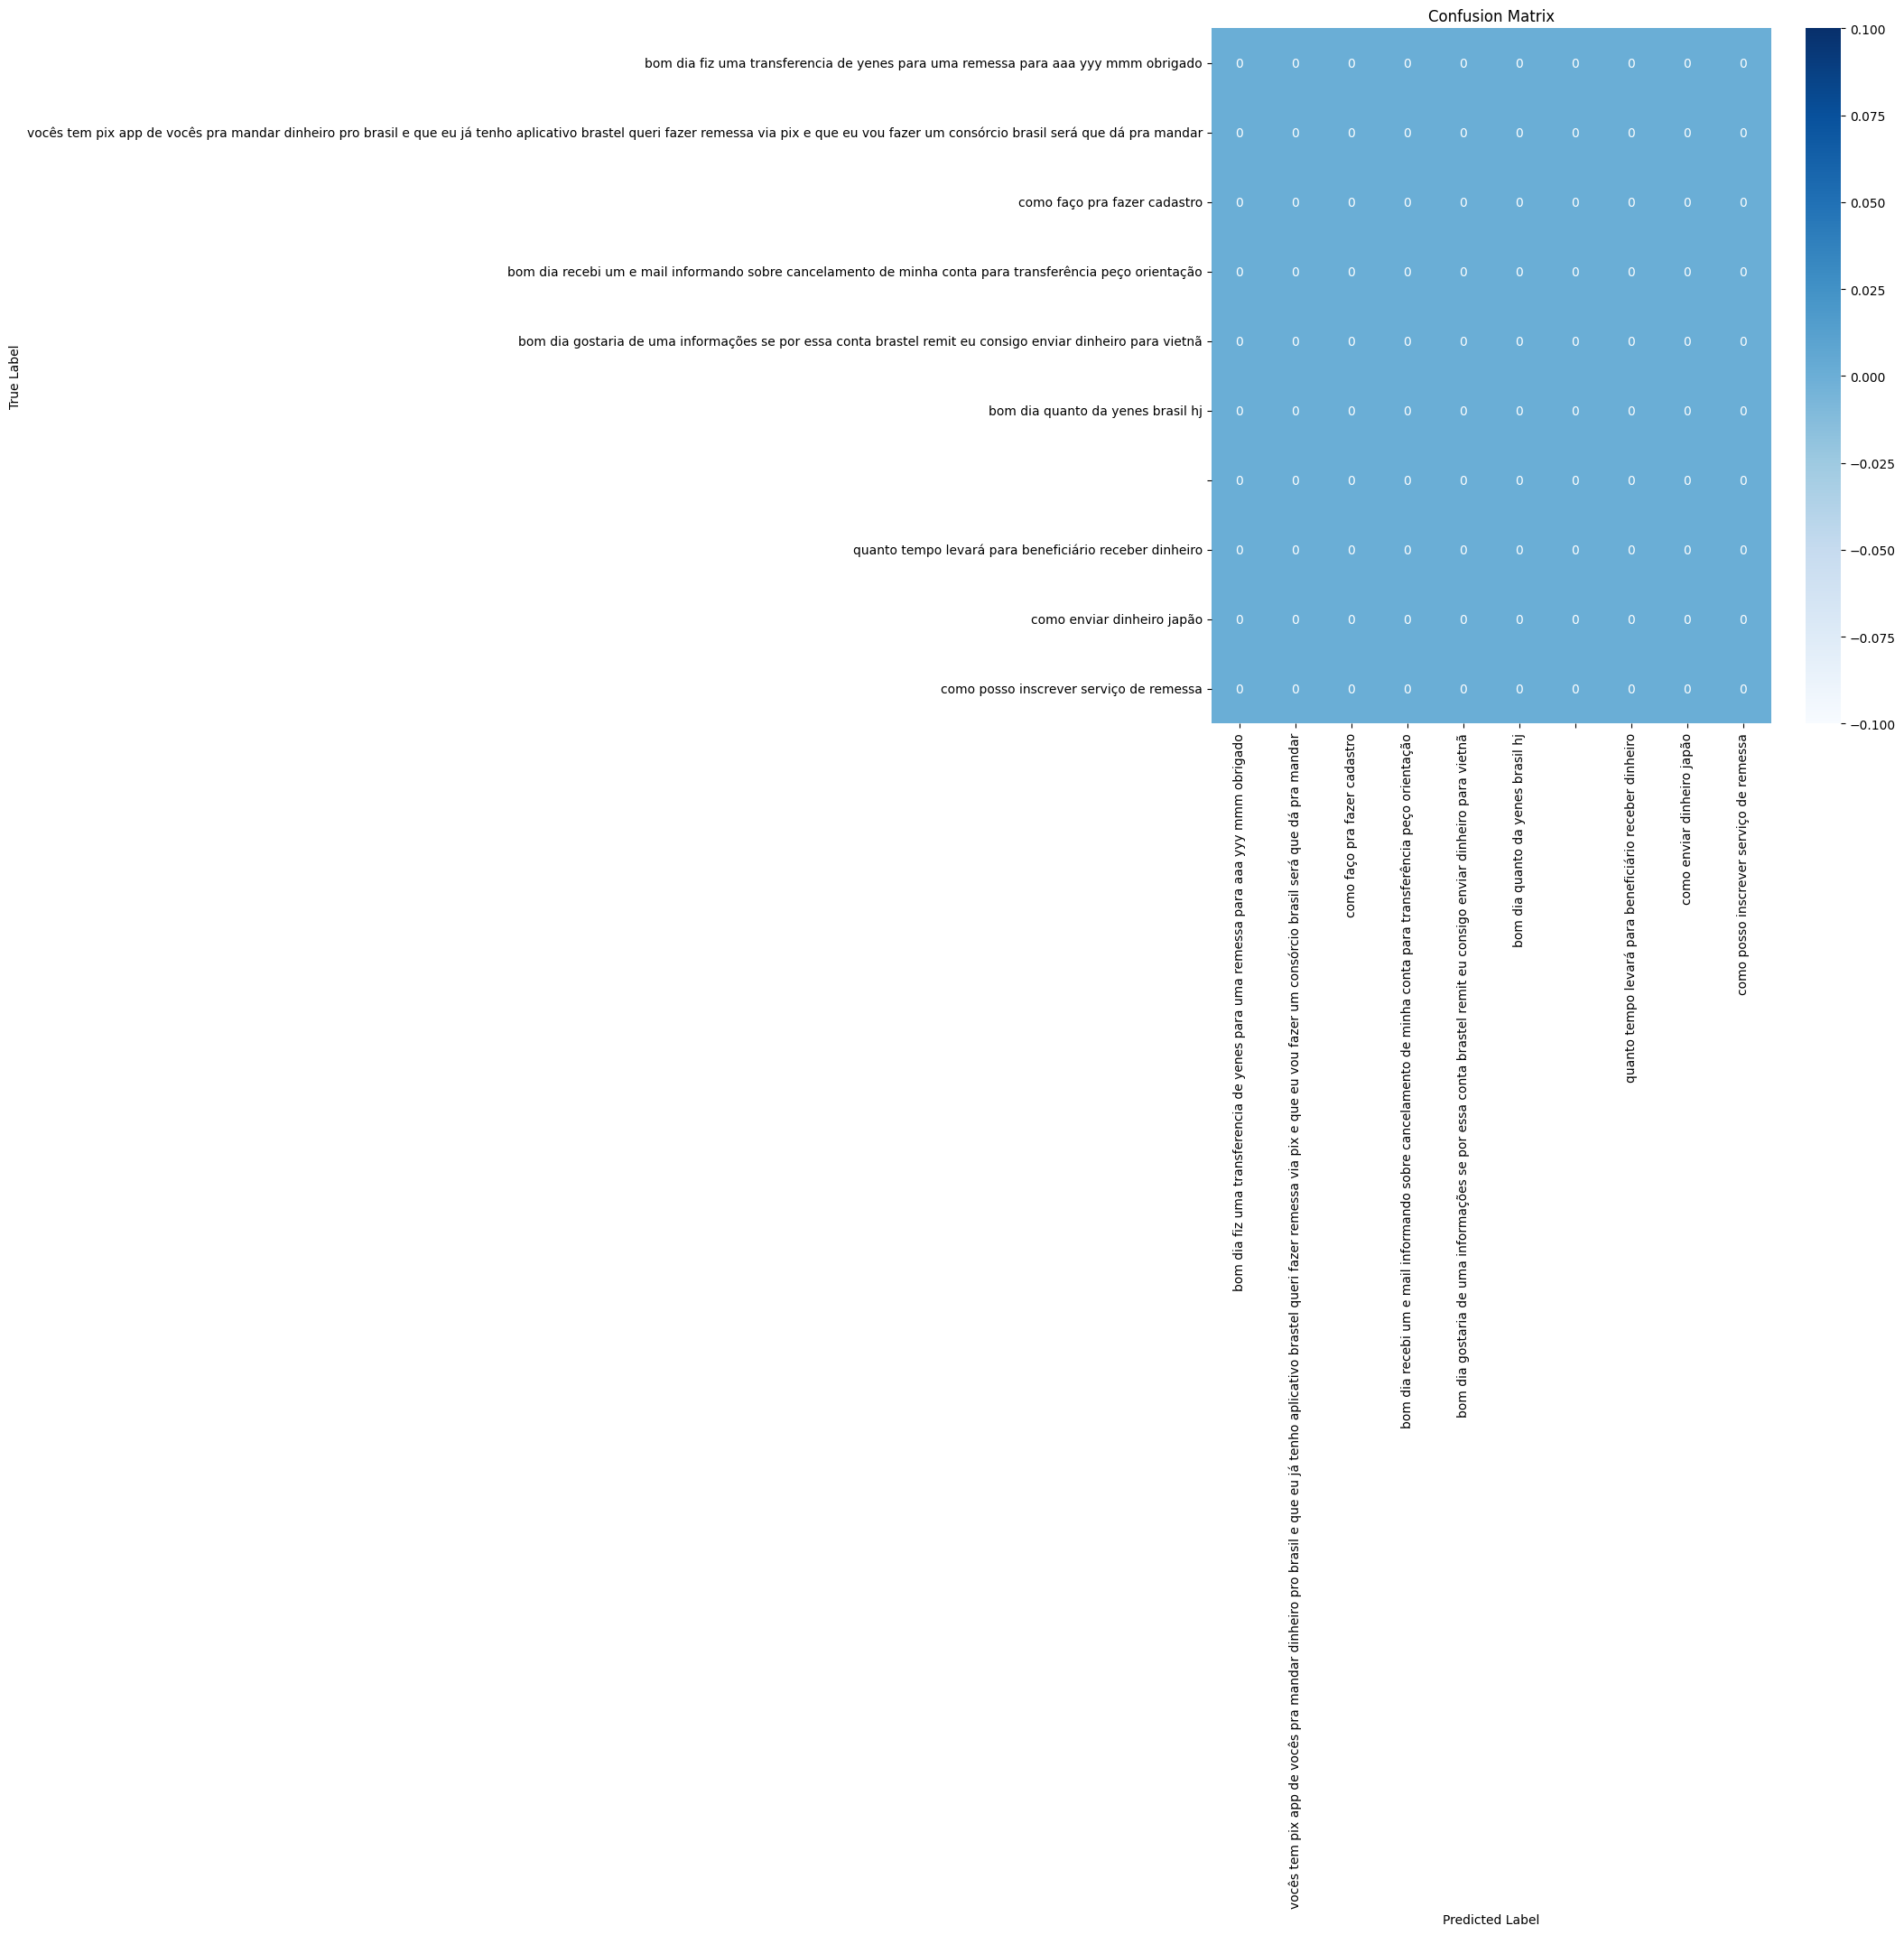

In [7]:
y_pred = model.predict(test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)

y_test_str = list(map(str, y_test))
y_pred_classes_str = list(map(str, y_pred_classes))

top_classes = 10

class_counts = np.bincount(y_test)

top_classes_indices = np.argsort(class_counts)[-top_classes:]

filtered_labels = [label_encoder.classes_[i] for i in top_classes_indices]

y_pred_filtered = [pred for true, pred in zip(y_test_str, y_pred_classes_str) if true in filtered_labels]
y_test_filtered = [true for true in y_test_str if true in filtered_labels]

conf_matrix = confusion_matrix(y_test_filtered, y_pred_filtered, labels=filtered_labels)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=filtered_labels, 
            yticklabels=filtered_labels)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


## Treinamento com Word2Vec

In [8]:
def get_word2vec_vectors(texts, model):
    vectors = []
    for text in texts:
        words = text.split()
        word_vectors = [model.wv[word] for word in words if word in model.wv]
        if len(word_vectors) > 0:
            vectors.append(np.mean(word_vectors, axis=0))
        else:
            vectors.append(np.zeros(model.vector_size))
    return vectors

sentences = [text.split() for text in X_train]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

train_word2vec = get_word2vec_vectors(X_train, word2vec_model)
test_word2vec = get_word2vec_vectors(X_test, word2vec_model)

print(f"Shape of first vector: {train_word2vec[0].shape}")
print(f"Shape of last vector: {train_word2vec[-1].shape}")

train_word2vec = np.array(train_word2vec)
test_word2vec = np.array(test_word2vec)


Shape of first vector: (100,)
Shape of last vector: (100,)


## SVM usando Word2Vec

In [9]:
labels = np.unique(y_train)

svc_pipeline = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))
svc_pipeline.fit(train_word2vec, y_train)

y_pred_svc = svc_pipeline.predict(test_word2vec)

report = classification_report(y_test, y_pred_svc, labels=labels, target_names=label_encoder.classes_[labels], output_dict=True)

report_df = pd.DataFrame(report).transpose()

report_df

/home/caze/.pyenv/versions/3.12.4/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/caze/.pyenv/versions/3.12.4/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/caze/.pyenv/versions/3.12.4/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()}

,precision,recall,f1-score,support
,0.750000,1.000000,0.857143,3.0
acabei de fazer depósito pelo cartão brastelremit quanto tempo lev para dinheiro sem creditado para poder transferir para brasil,0.000000,0.000000,0.000000,0.0
acabei de fazer uma remessa de para beneficiário rrr kkk,0.000000,0.000000,0.000000,0.0
acabei de fazer uma transferência de ienes poderia enviar para conta aa dd por gentileza,0.000000,0.000000,0.000000,0.0
agora foi foi feito uma remessa de dia quanto vai cair,0.000000,0.000000,0.000000,0.0
...,...,...,...,...
tenho cartão brastel não estou conseguindo depositar,0.000000,0.000000,0.000000,0.0
transferência posso fazer atm banco correio ou tem banco,0.000000,0.000000,0.000000,0.0
micro avg,0.178218,1.000000,0.302521,36.0
macro avg,0.029135,0.033835,0.030791,36.0


## Preparando para o Embedding Projector

In [10]:
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

words = list(word2vec_model.wv.index_to_key)
for word in words:
    vec = word2vec_model.wv[word]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")

out_v.close()
out_m.close()

print("Carregue os arquivos 'vecs.tsv' e 'meta.tsv' no Embedding Projector: https://projector.tensorflow.org/")

Carregue os arquivos 'vecs.tsv' e 'meta.tsv' no Embedding Projector: https://projector.tensorflow.org/
